In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate some data from two classes.
$ x_{Class A} \sim \mathrm{Uniform}(50,60)$ and $ x_{Class B} \sim \mathrm{Uniform}(60,70)$. 

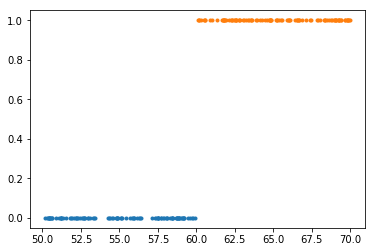

In [2]:
a = np.random.uniform(low=50, high=60, size=100)
b = np.random.uniform(low=60, high=70, size=100)

a_target = np.zeros((100,))
b_target = np.ones((100,))

x = np.concatenate([a, b])
y = np.concatenate([a_target, b_target])

plt.plot(a, a_target, '.')
plt.plot(b, b_target, '.')
plt.show()

In [3]:
def to_one_hot(array, depth):
  array_reshaped = np.reshape(array, -1).astype(np.uint8)
  array_one_hot = np.zeros((array_reshaped.shape[0], depth))
  array_one_hot[np.arange(array_reshaped.shape[0]), array_reshaped] = 1
  array_one_hot = np.reshape(array_one_hot, array.shape + (-1,))

  return array_one_hot

This simple logistic regression model only has 2 parameters, $w$ and $b$. 

In [4]:
def logistic_regression(x, w, b):
    prob = 1.0 / (1 + np.exp(-1 * w * x - b))
    return prob

def categorical_log_likelihood(prob, truth, num_classes):
    N = truth.shape[0]
    truth_one_hot = to_one_hot(truth, depth=num_classes)

    return np.sum(np.log(prob + 1e-8) * truth_one_hot) / N

## Maximum-a-posteriori estimate

Perform L2-regularized logistic regression or maximum-a-posteriori estimation of the parameters, $w$, and $b$. Below, we show a plot of the regularized log likelihood and the estimates of $w$ and $b$.

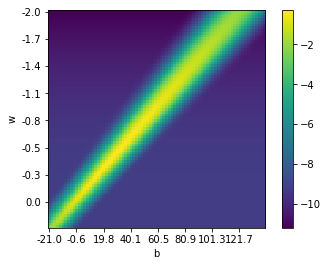

In [5]:
num_w = 80
num_b = 80

w_grid = np.linspace(-2.0, 0.3, num_w)
b_grid = np.linspace(-21, 140, num_b)

log_likelihood = np.zeros([num_w, num_b])

for i in range(num_w):
    for j in range(num_b):
        x_prob = logistic_regression(x, w_grid[i], b_grid[j])
        x_prob = np.stack([x_prob, 1- x_prob], axis=-1)
        log_likelihood[i,j] = categorical_log_likelihood(x_prob, y, num_classes=2) - 1.0*w_grid[i]**2 / 2.0

plt.imshow(log_likelihood)
plt.yticks(range(0, num_w, 10), np.around(w_grid[::10], decimals=1))
plt.xticks(range(0, num_b, 10), np.around(b_grid[::10], decimals=1))
plt.ylabel('w')
plt.xlabel('b')
plt.colorbar()
plt.show()

In [6]:
best_i, best_j = np.unravel_index(np.argmax(log_likelihood), log_likelihood.shape)

print('Best w: ', w_grid[best_i])
print('Best b: ', b_grid[best_j])

('Best w: ', -0.42784810126582284)
('Best b: ', 25.87341772151899)


We show the predicted probability of class A for points from 40 to 80. 

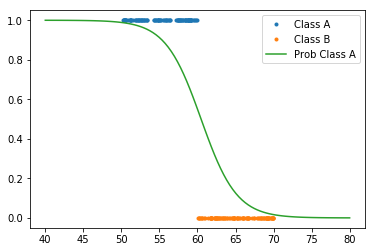

In [7]:
plt.plot(a, to_one_hot(a_target, depth=2)[:,0], '.', label='Class A')
plt.plot(b, to_one_hot(b_target, depth=2)[:,0], '.', label='Class B')

x_range = np.linspace(40,80,100)
y_range = logistic_regression(x_range, w_grid[best_i], b_grid[best_j])

plt.plot(x_range, y_range, label="Prob Class A")
plt.legend()
plt.show()

## Full Bayesian logistic regression by integrating over the posterior

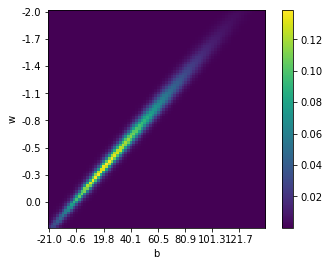

In [8]:
unnormalized_posterior = np.zeros([num_w, num_b])

for i in range(num_w):
    for j in range(num_b):
        x_prob = logistic_regression(x, w_grid[i], b_grid[j])
        x_prob = np.stack([x_prob, 1- x_prob], axis=-1)
        log_likelihood = categorical_log_likelihood(x_prob, y, num_classes=2)
        likelihood = np.exp(log_likelihood)
        prior = 0.5 / np.sqrt(2*np.pi) * np.exp(-1 * w_grid[i] ** 2)
        
        unnormalized_posterior[i, j] = likelihood * prior

posterior = unnormalized_posterior / np.sum(unnormalized_posterior)

plt.imshow(unnormalized_posterior)
plt.yticks(range(0, num_w, 10), np.around(w_grid[::10], decimals=1))
plt.xticks(range(0, num_b, 10), np.around(b_grid[::10], decimals=1))
plt.ylabel('w')
plt.xlabel('b')
plt.colorbar()
plt.show()

Again, we show the predicted probability of class A for points from 40 to 80. Note that the full Bayesian approach shows "softer" probability predictions.

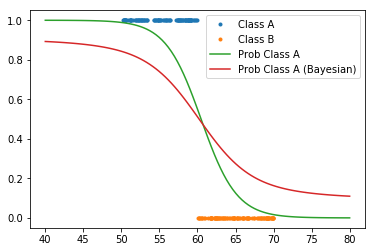

In [9]:
y_range_prob = np.zeros([len(x_range), num_w, num_b])

for i in range(num_w):
    for j in range(num_b):
        y_range_prob[:,i,j] = logistic_regression(x_range, w_grid[i], b_grid[j])

y_range_bayesian = np.sum(y_range_prob * posterior, axis=(1,2))

plt.plot(a, to_one_hot(a_target, depth=2)[:,0], '.', label='Class A')
plt.plot(b, to_one_hot(b_target, depth=2)[:,0], '.', label='Class B')
plt.plot(x_range, y_range, label="Prob Class A")
plt.plot(x_range, y_range_bayesian, label="Prob Class A (Bayesian)")
plt.legend()
plt.show()